## Main idea: to find the best location/district for placement solar panels
How I did it:

#### import

In [ ]:
# !pip install geovoronoi sqlalchemy GeoAlchemy2

In [4]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
from shapely.geometry import Point
import geovoronoi
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from sqlalchemy import create_engine
import folium
import numpy as np

In [34]:
import warnings
warnings.filterwarnings('ignore')

### 1. Download data annual sum of station observations of sunshine duration in hour from dwd.de (Deutscher Wetterdienst).
I took data between 2017 and 2022/2023 (it depends on station and approach of collecting data and presence of correction).

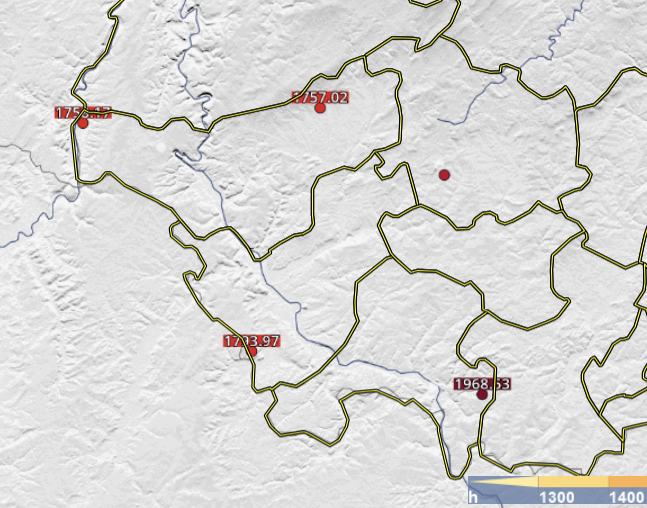

In [15]:
# source of data - https://cdc.dwd.de/portal/202209231028/mapview
bases = pd.read_csv(r"C:\Users\danil\Desktop\Trier\Internship\Credium project\cdc_download_2024-10-25_13_27\data\sdo_OBS_DEU_P1Y_SD_S.csv")
bases['Geogr_Laenge'] = bases['Geogr_Laenge'].str.replace(",", ".").astype(float)
bases['Geogr_Breite'] = bases['Geogr_Breite'].str.replace(",", ".").astype(float)
bases['geometry'] = bases.apply(lambda row: Point(row['Geogr_Laenge'], row['Geogr_Breite']), axis=1)
bases = gpd.GeoDataFrame(bases, crs='epsg:4326')
bases.explore()

In [17]:
bases_info = pd.read_csv(r"C:\Users\danil\Desktop\Trier\Internship\Credium project\cdc_download_2024-10-25_13_27\data\data_OBS_DEU_P1Y_SD_S.csv", index_col = False)
bases_info = pd.pivot_table(bases_info, columns = 'SDO_ID', aggfunc = 'mean')
bases_info = bases_info.T
bases_info

,Qualitaet_Byte,Qualitaet_Niveau,Wert
SDO_ID,,,
44,4.0,8.833333,1717.835000
71,4.0,10.000000,1888.566667
73,4.0,10.000000,1974.780000
102,4.0,3.000000,2021.800000
131,4.0,9.000000,1844.857143
...,...,...,...
13965,4.0,7.500000,2001.220000
15000,4.0,8.428571,1799.524286
15207,4.0,8.000000,1781.286667


In [18]:
bases = bases.join(bases_info, how = 'left', on = 'SDO_ID')
bases.reset_index(inplace = True)
bases = bases[['SDO_ID', 'SDO_Name', 'geometry', 'Wert']]
bases['Wert'] = bases['Wert'].round(0)
bases

,SDO_ID,SDO_Name,geometry,Wert
0,3426,"Muskau, Bad",POINT (14.70080 51.56600),1908.0
1,1420,Frankfurt/Main,POINT (8.52130 50.02590),1959.0
2,1832,Großer Arber,POINT (13.13380 49.11290),1691.0
3,3761,Öhringen,POINT (9.51760 49.20700),1917.0
4,4560,Schotten,POINT (9.12260 50.49250),1704.0
...,...,...,...,...
294,102,Leuchtturm Alte Weser,POINT (8.12750 53.86330),2022.0
295,5822,Bassum,POINT (8.69890 52.86300),1722.0
296,161,Andernach,POINT (7.42020 50.42370),1824.0
297,3623,Nörvenich-Niederbolheim,POINT (6.66010 50.82940),1957.0


### 2. Download borders of districts in Saarland

In [19]:
area_name = 'Saarland'
area = ox.geocode_to_gdf(area_name)
# area.explore(tiles = 'CartoDB positron')
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((6.35579 49.53039, 6.35579 49.53021, ...",49.639427,49.111951,7.404831,6.355791,102823871,relation,62372,49.384187,6.953737,boundary,administrative,8,0.641395,state,Saarland,"Saarland, Germany"


In [20]:
tags = {'admin_level': '6'}  # districts have this admin_level in OSM classification
border = ox.features_from_polygon(area.unary_union, tags)   
border.reset_index(inplace = True)
border = border[(border.element_type != 'node') & (border.element_type != 'way')]    # drop borders as nodes and way
border = border[border.geometry.within(area.unary_union)]
border = border[border.geometry.intersects(bases.unary_union)]  # filter borders and choose distrincts with stations
bases = bases[bases.geometry.intersects(border.unary_union)]   
border.explore(tiles = 'CartoDB positron')  

### 3. Make Voronoi polygons. Voronoi diagram is a partition of a plane into regions close to each of a given set of objects.

In [21]:
poly_shapes, poly_to_pt_assignments = voronoi_regions_from_coords(bases['geometry'], border['geometry'].unary_union)
poly_vor = gpd.GeoDataFrame(index = list(poly_shapes.keys()), crs='epsg:4326', geometry = list(poly_shapes.values()))
poly_vor.explore()

In [41]:
poly_vor = gpd.sjoin(poly_vor, bases , how='inner', op='intersects')[['geometry', 'SDO_ID', 'SDO_Name', 'Wert']]
poly_vor

,geometry,SDO_ID,SDO_Name,Wert
0,"POLYGON ((6.54881 49.41787, 6.54987 49.41730, ...",460,Berus,1899.0
1,"POLYGON ((6.59837 49.47411, 6.59651 49.51878, ...",5433,Weiskirchen/Saar,1841.0
2,"MULTIPOLYGON (((6.53755 49.40791, 6.53728 49.4...",3904,Perl-Nennig,1845.0
3,"POLYGON ((7.05930 49.33919, 7.05948 49.33894, ...",4336,Saarbrücken-Ensheim,2002.0
4,"MULTIPOLYGON (((7.07541 49.34436, 7.07555 49.3...",5029,Tholey,1910.0


### 4. Download data about buildings, filter it and load to postgis database

In [22]:
tags = {'building': True} # tags dictionary
# buildings = ox.geometries_from_polygon(border.unary_union, tags) 
# buildings1 = buildings
# buildings = buildings1.copy()

In [47]:
buildings.reset_index(inplace = True)
buildings = buildings[buildings.element_type != 'node']    # filter buildings as Points
# buildings[(buildings.element_type != 'node') & (buildings.geom_type != 'MultiPolygon')]   # if multipolygons will be the souce of mistakes
buildings.head()

,element_type,osmid,ele,name,place,wikidata,wikipedia,geometry,access,step_count,...,service:bicycle:diy,ways,proposed:name,parts,repair,safety_inspection,sale,shop:tyres,tyres,fuel:adblue
399,way,15031513,NaN,NaN,NaN,NaN,NaN,"POLYGON ((7.02636 49.20897, 7.02661 49.20912, ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,way,15234403,NaN,Musikschule Obere Saar,NaN,NaN,NaN,"POLYGON ((7.06542 49.13002, 7.06578 49.13011, ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,way,16311078,NaN,Ruppertshof,NaN,NaN,NaN,"POLYGON ((7.05592 49.14090, 7.05637 49.14096, ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,way,23804730,NaN,NaN,NaN,NaN,NaN,"POLYGON ((6.89863 49.22934, 6.89847 49.22967, ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,way,23937017,NaN,Parkhaus,NaN,NaN,NaN,"POLYGON ((6.99234 49.22105, 6.99235 49.22101, ...",yes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# choose columns with useful data
null_counts = buildings.isna().sum()
null_counts = null_counts[null_counts < len(buildings)*0.9] 
null_counts

osmid                    0
building                 0
addr:city           151481
addr:housenumber    148122
addr:postcode       148613
addr:street         148075
geometry                 0
dtype: int64

In [27]:
# additional analysis of separate columns
value_counts = buildings.building.value_counts()
value_counts = list(value_counts.index)
value_counts

['yes',
 'garage',
 'house',
 'apartments',
 'detached',
 'residential',
 'garages',
 'roof',
 'semidetached_house',
 'industrial',
 'commercial',
 'service',
 'shed',
 'bungalow',
 'allotment_house',
 'terrace',
 'retail',
 'office',
 'school',
 'carport',
 'church',
 'greenhouse',
 'university',
 'hospital',
 'stable',
 'chapel',
 'bunker',
 'farm_auxiliary',
 'hut',
 'container',
 'public',
 'warehouse',
 'kindergarten',
 'transformer_tower',
 'government',
 'storage_tank',
 'construction',
 'farm',
 'hotel',
 'dwelling_house',
 'sports_centre',
 'sports_hall',
 'parking',
 'cabin',
 'train_station',
 'barn',
 'fire_station',
 'civic',
 'static_caravan',
 'dormitory',
 'chalet',
 'ruins',
 'college',
 'grandstand',
 'passage',
 'supermarket',
 'cowshed',
 'kiosk',
 'toilets',
 'manufacture',
 'shelter',
 'tower',
 'riding_hall',
 'bridge',
 'digester',
 'museum',
 'funeral_hall',
 'staircase',
 'transportation',
 'hangar',
 'castle',
 'passageway',
 'villa',
 'stadium',
 'silo',
 'n

In [28]:
# filter df
buildings = buildings.filter(items = [item for item in list(null_counts.index) if item not in ['nodes', 'addr:country', 'element_type']])
buildings.reset_index(inplace = True, drop = True)
buildings.head()

,osmid,building,addr:city,addr:housenumber,addr:postcode,addr:street,geometry
0,15031513,yes,Saarbrücken,4,66130,Wolfsau,"POLYGON ((7.02636 49.20897, 7.02661 49.20912, ..."
1,15234403,yes,Kleinblittersdorf,1a,66271,Siedlerstraße,"POLYGON ((7.06542 49.13002, 7.06578 49.13011, ..."
2,16311078,yes,Kleinblittersdorf,42,66271,Ruppertstraße,"POLYGON ((7.05592 49.14090, 7.05637 49.14096, ..."
3,23804730,school,None,53,66127,Hauptstraße,"POLYGON ((6.89863 49.22934, 6.89847 49.22967, ..."
4,23937017,parking,Saarbrücken,118,66119,Theodor-Heuss-Straße,"POLYGON ((6.99234 49.22105, 6.99235 49.22101, ..."


In [29]:
# calculation of area in m2
buildings_area = buildings.copy()
buildings_area = buildings_area.to_crs(epsg=32633)  # Change to a suitable UTM CRS
buildings_area['area_m2'] = buildings_area.geometry.area
buildings_area

,osmid,building,addr:city,addr:housenumber,addr:postcode,addr:street,geometry,area_m2
0,15031513,yes,Saarbrücken,4,66130,Wolfsau,"POLYGON ((-80490.713 5481359.723, -80470.714 5...",14540.507001
1,15234403,yes,Kleinblittersdorf,1a,66271,Siedlerstraße,"POLYGON ((-78573.613 5472295.143, -78546.509 5...",397.039267
2,16311078,yes,Kleinblittersdorf,42,66271,Ruppertstraße,"POLYGON ((-79138.488 5473575.038, -79105.000 5...",1095.194703
3,23804730,school,None,53,66127,Hauptstraße,"POLYGON ((-89536.485 5484613.948, -89544.299 5...",1672.434784
4,23937017,parking,Saarbrücken,118,66119,Theodor-Heuss-Straße,"POLYGON ((-82821.774 5482963.925, -82821.438 5...",3064.965886
...,...,...,...,...,...,...,...,...
378790,17011757,office,Saarbrücken,8,66111,Am Stadtgraben,"POLYGON ((-82549.024 5484202.694, -82546.934 5...",1915.905908
378791,17043385,monastery,Püttlingen,197,66346,Völklinger Straße,"POLYGON ((-90471.741 5490002.250, -90477.611 5...",1790.158703
378792,17344363,hospital,None,None,None,None,"POLYGON ((-82395.260 5482944.664, -82386.656 5...",1717.787125
378793,17348138,yes,None,None,None,None,"POLYGON ((-84806.920 5481635.440, -84809.249 5...",5.913928


In [39]:
# join to first db with geographical coordinates
buildings1 = buildings.set_index('osmid').join(buildings_area.set_index('osmid')[['area_m2']], how = 'left', on = 'osmid')
buildings1

,building,addr:city,addr:housenumber,addr:postcode,addr:street,geometry,area_m2
osmid,,,,,,,
15031513,yes,Saarbrücken,4,66130,Wolfsau,"POLYGON ((7.02636 49.20897, 7.02661 49.20912, ...",14540.507001
15234403,yes,Kleinblittersdorf,1a,66271,Siedlerstraße,"POLYGON ((7.06542 49.13002, 7.06578 49.13011, ...",397.039267
16311078,yes,Kleinblittersdorf,42,66271,Ruppertstraße,"POLYGON ((7.05592 49.14090, 7.05637 49.14096, ...",1095.194703
23804730,school,None,53,66127,Hauptstraße,"POLYGON ((6.89863 49.22934, 6.89847 49.22967, ...",1672.434784
23937017,parking,Saarbrücken,118,66119,Theodor-Heuss-Straße,"POLYGON ((6.99234 49.22105, 6.99235 49.22101, ...",3064.965886
...,...,...,...,...,...,...,...
17011757,office,Saarbrücken,8,66111,Am Stadtgraben,"POLYGON ((6.99426 49.23235, 6.99430 49.23227, ...",1915.905908
17043385,monastery,Püttlingen,197,66346,Völklinger Straße,"POLYGON ((6.87799 49.27643, 6.87789 49.27651, ...",1790.158703
17344363,hospital,None,None,None,None,"POLYGON ((6.99817 49.22129, 6.99829 49.22129, ...",1717.787125


In [43]:
buildings_pol = gpd.sjoin(buildings1, poly_vor, how='left', op='intersects')
buildings_pol = buildings_pol.groupby(buildings_pol.index).first().reset_index()
buildings_pol.head()

,osmid,building,addr:city,addr:housenumber,addr:postcode,addr:street,geometry,area_m2,index_right,SDO_ID,SDO_Name,Wert
0,557835,yes,Sankt Wendel,6,66606,Leipziger Straße,"POLYGON ((7.15218 49.46351, 7.15218 49.46352, ...",5308.494293,4,5029,Tholey,1910.0
1,1067556,government,Saarbrücken,14A,66117,Am Ludwigsplatz,"POLYGON ((6.98629 49.23316, 6.98629 49.23319, ...",2030.380136,3,4336,Saarbrücken-Ensheim,2002.0
2,1316195,university,Saarbrücken,B4 1,66123,Campus,"POLYGON ((7.04057 49.25298, 7.04083 49.25300, ...",7418.094855,3,4336,Saarbrücken-Ensheim,2002.0
3,1352072,yes,None,None,None,None,"POLYGON ((7.02674 49.22356, 7.02662 49.22353, ...",1134.497743,3,4336,Saarbrücken-Ensheim,2002.0
4,1352223,yes,None,None,None,None,"POLYGON ((7.01279 49.22950, 7.01281 49.22958, ...",1064.222781,3,4336,Saarbrücken-Ensheim,2002.0


In [37]:
# loading to Postgis
user = "******"
password = "******"
host = "localhost"
port = "5432"
db_name = "gisdb"

# Create a connection string
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)
table_name = "Postgis_table_1"
buildings.to_postgis(table_name, engine, if_exists='replace')

### 5. Aggregation of 3 buildings groups (garage, house and industrial) for possible placement. 
I chose buildings with area > 100 m2 and summarized it to hectare

In [44]:
garage = buildings_pol[((buildings_pol.building == 'garages') | (buildings_pol.building == 'garage')) & (buildings_pol.area_m2 >= 100)].dissolve(by=['SDO_ID', 'SDO_Name', 'Wert'], aggfunc={'area_m2': 'sum'}) #.reset_index(inplace = True)
garage.reset_index(inplace = True)
garage = garage[['SDO_ID','area_m2']].rename(columns={"area_m2": "garage_hectare"})
garage['garage_hectare'] = (garage['garage_hectare'] / 10000).round(1)
house = buildings_pol[((buildings_pol.building == 'house') | (buildings_pol.building == 'apartments') | (buildings_pol.building == 'residential')) & (buildings_pol.area_m2 >= 100)].dissolve(by=['SDO_ID', 'SDO_Name', 'Wert'], aggfunc={'area_m2': 'sum'})
house.reset_index(inplace = True)
house = house[['SDO_ID','area_m2']].rename(columns={"area_m2": "house_hectare"})
house['house_hectare'] = (house['house_hectare'] / 10000).round(1)
industrial = buildings_pol[((buildings_pol.building == 'industrial') | (buildings_pol.building == 'commercial')) & (buildings_pol.area_m2 >= 100)].dissolve(by=['SDO_ID', 'SDO_Name', 'Wert'], aggfunc={'area_m2': 'sum'})
industrial.reset_index(inplace = True)
industrial = industrial[['SDO_ID','area_m2']].rename(columns={"area_m2": "industrial_hectare"})
industrial['industrial_hectare'] = (industrial['industrial_hectare'] / 10000).round(1)

In [45]:
polygons = poly_vor.set_index('SDO_ID').join(garage.set_index('SDO_ID'), how='left', on = 'SDO_ID')
polygons = polygons.join(house.set_index('SDO_ID'), how='left', on = 'SDO_ID')
polygons = polygons.join(industrial.set_index('SDO_ID'), how='left', on = 'SDO_ID')
polygons

,geometry,SDO_Name,Wert,garage_hectare,house_hectare,industrial_hectare
SDO_ID,,,,,,
460,"POLYGON ((6.54881 49.41787, 6.54987 49.41730, ...",Berus,1899.0,4.8,43.6,164.8
5433,"POLYGON ((6.59837 49.47411, 6.59651 49.51878, ...",Weiskirchen/Saar,1841.0,1.1,30.6,31.0
3904,"MULTIPOLYGON (((6.53755 49.40791, 6.53728 49.4...",Perl-Nennig,1845.0,0.2,3.4,2.3
4336,"POLYGON ((7.05930 49.33919, 7.05948 49.33894, ...",Saarbrücken-Ensheim,2002.0,7.6,103.6,92.9
5029,"MULTIPOLYGON (((7.07541 49.34436, 7.07555 49.3...",Tholey,1910.0,2.7,54.7,24.1


### 6. Final visualisation

In [46]:
map1 = polygons.explore(
    column='Wert', 
    tiles='CartoDB positron',
    name='Wert',
    cmap = 'viridis'
)
polygons.explore(
    m=map1,           # Add to the existing map
    column='garage_hectare', 
    name='garage_hectare'
)
polygons.explore(
    m=map1,          
    column='house_hectare', 
    name='house_hectare'
)
polygons.explore(
    m=map1,          
    column='industrial_hectare', 
    name='industrial_hectare'
)
folium.LayerControl().add_to(map1)
map1

### 7. PostGIS Query

In [29]:
user = "*****"
password = "******"
host = "localhost"
port = "5432"
db_name = "gisdb"

connection_string = f"postgresql://{user}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)

query = 'SELECT * FROM "Postgis_table_1" LIMIT 10'

gdf = gpd.read_postgis(query, engine, geom_col='geometry')
gdf.head()

,osmid,building,addr:city,addr:housenumber,addr:postcode,addr:street,geometry
0,15031513,yes,Saarbrücken,4,66130,Wolfsau,"POLYGON ((7.02636 49.20897, 7.02661 49.20912, ..."
1,15234403,yes,Kleinblittersdorf,1a,66271,Siedlerstraße,"POLYGON ((7.06542 49.13002, 7.06578 49.13011, ..."
2,16311078,yes,Kleinblittersdorf,42,66271,Ruppertstraße,"POLYGON ((7.05592 49.14090, 7.05637 49.14096, ..."
3,23804730,school,None,53,66127,Hauptstraße,"POLYGON ((6.89863 49.22934, 6.89847 49.22967, ..."
4,23937017,parking,Saarbrücken,118,66119,Theodor-Heuss-Straße,"POLYGON ((6.99234 49.22105, 6.99235 49.22101, ..."
